In [257]:
%matplotlib inline

import numpy as np
from scipy.stats import uniform, expon, lognorm, weibull_min, chi2, wasserstein_distance, moment
from scipy.special import gamma
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA

### Distributions of the independent components

In [32]:
rvs = [uniform(), expon(scale=0.1), lognorm(s=1), weibull_min(c=2), chi2(df=4)]

In [33]:
def sample_normed(n, rv):
    return (rv.rvs(size=n) - rv.mean()) / rv.std()

In [34]:
n = 5000
eps = np.zeros((n,len(rvs)))
for i, rv in enumerate(rvs):
    eps[:,i] = sample_normed(n,rv)

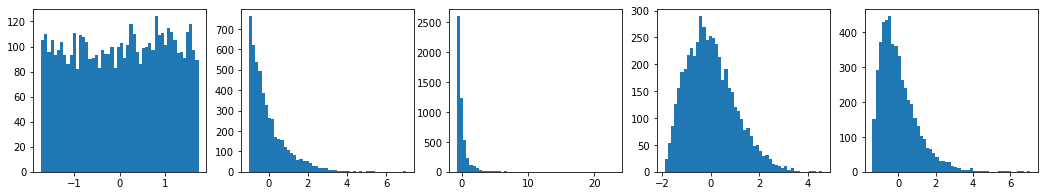

In [35]:
fig, ax = plt.subplots(1, 5, figsize=(18,3))

for j in range(5):
        ax[j].hist(eps[:,j], bins=50)

plt.show()

### Create synthetic observations

In [269]:
nlat = 5
joint_latents = [0,1]
env1_specific = [2]
env2_specific = [3]
env3_specific = [4]
d1 = 10
d2 = 11
d3 = 12
n1 = 1000
n2 = 1000
n3 = 1000

env1_latents = joint_latents + env1_specific
env2_latents = joint_latents + env2_specific
env3_latents = joint_latents + env3_specific

In [270]:
def matrix_from_normal(shape, mu=0, sigma=1):
    A = np.random.normal(loc=mu, scale=sigma, size=shape)
    return A

In [271]:
# Sample entries of G1
#np.random.seed(101)
G1 = matrix_from_normal(shape=(d1,len(env1_latents)))
G1

array([[-0.08802427,  0.54975488,  1.56144885],
       [-1.14346016,  0.7338579 ,  1.09507609],
       [-2.3209222 ,  0.05205289, -1.29016886],
       [ 0.20974025, -0.56279297,  1.26114224],
       [ 0.36027105, -0.97185402, -2.08008809],
       [ 1.40795859, -1.0010028 , -0.35412515],
       [ 0.94770965, -0.48934807, -1.04120748],
       [ 1.81974903,  0.07609307,  1.3791846 ],
       [ 0.84156477, -0.44670537, -0.01246162],
       [-1.42680821,  1.76662127, -0.63434487]])

In [272]:
# G2 and G3
#np.random.seed(102)
G2 = matrix_from_normal(shape=(d2,len(env2_latents)))

#np.random.seed(103)
G3 = matrix_from_normal(shape=(d3,len(env3_latents)))

In [273]:
def sample(n, mixing, rvs):
    nr_comps = len(rvs)
    eps = np.zeros((n,nr_comps))
    for i, rv in enumerate(rvs):
        eps[:,i] = sample_normed(n,rv)
    X = np.matmul(mixing, np.transpose(eps))
    return(X)

In [274]:
# Create synthetic data (uncoupled!!)
X1 = sample(n1, G1, [rvs[i] for i in env1_latents])
X2 = sample(n2, G2, [rvs[i] for i in env2_latents])
X3 = sample(n3, G3, [rvs[i] for i in env3_latents])

### Apply linear ICA to recover the (empirical) distribution of the sources

In [275]:
def rescale_columns(X):
    for i in range(X.shape[1]):
        X[:,i] = (X[:,i] - X[:,i].mean()) / X[:,i].std()
    return X

# X1 has shape p x n
def get_sources(X, seed=101):
    cov = np.cov(X)
    rk = np.linalg.matrix_rank(cov)
    print("Rank:", rk)
    
    ICA = FastICA(n_components=rk, random_state=seed, whiten='unit-variance', max_iter=1000) 
    ICA.fit(np.transpose(X))
    print("Iterations:", ICA.n_iter_)
    eps = ICA.transform(np.transpose(X))
    scaling = eps.std(axis=0)
    
    eps = rescale_columns(eps)
    mixing = np.matmul(ICA.mixing_, np.diag(scaling))    
    
    return eps, mixing

In [276]:
eps1, mixing1 = get_sources(X1)

Rank: 3
Iterations: 4


In [277]:
mixing1

array([[-0.1115796 ,  1.56006972,  0.56804286],
       [-1.1450373 ,  1.10281261,  0.81023247],
       [-2.2691735 , -1.26157293,  0.17912988],
       [ 0.18413441,  1.2861744 , -0.55909248],
       [ 0.38781812, -2.07520783, -1.00953745],
       [ 1.39286152, -0.35166999, -1.08414821],
       [ 0.95161821, -1.0525088 , -0.55473868],
       [ 1.77332567,  1.3564535 , -0.02042056],
       [ 0.82963154, -0.0138981 , -0.49523366],
       [-1.39255727, -0.66910253,  1.83611623]])

In [278]:
eps2, mixing2 = get_sources(X2, seed=102)

Rank: 3
Iterations: 4


In [279]:
eps3, mixing3 = get_sources(X3, seed=103)

Rank: 3
Iterations: 5


In [280]:
# Collect results
indep_comps = [eps1, eps2, eps3]
mixings = [mixing1, mixing2, mixing3]

### Plot recovered distributions

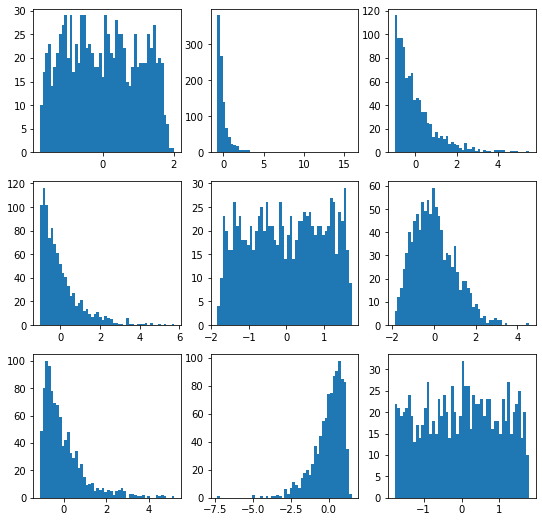

In [281]:
fig, ax = plt.subplots(3, 3, figsize=(9, 9))

for i in range(3):
    for j in range(3):
        ax[i,j].hist(indep_comps[i][:,j], bins=50)

plt.show()

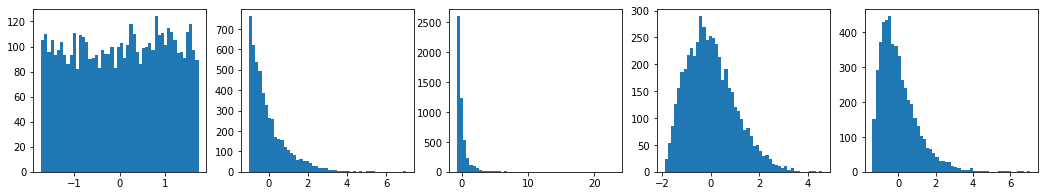

In [282]:
# Compare with "true" distributions

fig, ax = plt.subplots(1, 5, figsize=(18,3))

for j in range(5):
        ax[j].hist(eps[:,j], bins=50)

plt.show()

### Matching

In [283]:
def third_moments_distance(X,Y):
    M_X = moment(X, moment=3) # central moment
    M_Y = moment(Y, moment=3)
    dist = abs(M_X - M_Y)
    return dist

In [284]:
third_moments_distance(eps1[:,1],eps2[:,1])

6.103611718711264

In [285]:
# 1-Wasserstein metric between empirical distributions

def wasserstein_dist(X1,X2):
    p1 = X1.shape[1]
    p2 = X2.shape[1]
    D = np.zeros((p1,p2))
    for i in range(p1):
        for j in range(p2):
            D[i,j] = wasserstein_distance(X1[:,i],X2[:,j]) 
    return D


def wasserstein_dist_signed(X1,X2):
    p1 = X1.shape[1]
    p2 = X2.shape[1]
    D_large = np.zeros((p1,2*p2))
    X2_large = np.concatenate((X2,-X2),axis=1)
    for i in range(p1):
        for j in range(2*p2):
            D_large[i,j] = wasserstein_distance(X1[:,i],X2_large[:,j]) 
    D = np.zeros((p1,p2))
    for i in range(p2):
        D[:,i] = D_large[:,[i,i+p2]].min(axis=1)
    return D

In [303]:
def minimum_matching(D, A=10):
    p1, p2 = D.shape
    threshold = A * D.min()
    matching = {}
    for i in range(p1):
        row_argmin = D[i,:].argmin()
        row_min = D[i,:].min()
        if (D[:,row_argmin].argmin() == i) and (row_min < threshold):
            matching[i] = row_argmin
    return matching

In [304]:
D12 = wasserstein_dist_signed(eps1,eps2)
D12.round(3)

array([[0.368, 0.021, 0.152],
       [0.207, 0.531, 0.386],
       [0.019, 0.372, 0.227]])

In [306]:
minimum_matching(D12)

{0: 1, 2: 0}

In [307]:
D13 = wasserstein_dist_signed(eps1,eps3)
D13.round(3)

array([[0.377, 0.28 , 0.028],
       [0.211, 0.269, 0.522],
       [0.029, 0.091, 0.368]])

In [308]:
minimum_matching(D13)

{0: 2, 2: 0}

In [309]:
D23 = wasserstein_dist_signed(eps2,eps3)
D23.round(3)

array([[0.033, 0.094, 0.372],
       [0.386, 0.289, 0.031],
       [0.239, 0.14 , 0.146]])

In [310]:
minimum_matching(D23)

{0: 0, 1: 2}

In [311]:
# Definition of a joint factor:
# A collection of distributions of size |E| such that 
# - all distibutions within that joint factor match

In [312]:
def is_consistent(f, matchings):
    for i in range(len(f)):
        for j in range(i+1, len(f)):
            if f[i] not in list(matchings[str(i)+str(j)].keys()):
                return False
            if matchings[str(i)+str(j)][f[i]] != f[j]:
                return False
    return True



def get_joint_factors(indep_comps):
    
    nr_env = len(indep_comps)
    
    matchings = {}
    for i in range(nr_env):
        for j in range(i+1, nr_env):
            D = wasserstein_dist_signed(indep_comps[i],indep_comps[j])
            matchings[str(i)+str(j)] = minimum_matching(D)
    
    # Define potential factors
    pot_factors = [[i] for i in list(matchings['01'].keys())] 
    for f in pot_factors:
        for i in range(1,nr_env):
            if f[0] not in list(matchings['0'+str(i)].keys()):
                continue
            else:
                f.append(matchings['0'+str(i)][f[0]])
    pot_factors = [f for f in pot_factors if len(f)==nr_env]
    
    # Only keep consistent factors
    factors = [f for f in pot_factors if is_consistent(f, matchings)]
    
    return(factors)

In [313]:
joint_factors = get_joint_factors(indep_comps)
joint_factors

# Interpretation:
# We match the following recovered components:
# component 0 of domain 1 WITH component 0 of domain 2 WITH component 2 of domain 3

[[0, 1, 2], [2, 0, 0]]

### Recover joint mixing matrix

In [314]:
def matching_sign(distr1, distr2):
        normal_dist = wasserstein_distance(distr1,distr2) 
        flipped_dist = wasserstein_distance(distr1,-distr2)
        if normal_dist <= flipped_dist:
            return 1
        else:
            return -1 

In [315]:
def add_signs_to_factor(f, indep_comps):
    
    signs = [1]
    
    for i in range(1,len(f)):
        signs.append(matching_sign(indep_comps[0][:,f[0]], indep_comps[i][:,f[i]]))
         
    # Check for consistency
    for i in range(1, len(f)):
        for j in range(i+1, len(f)):
            if signs[i]*signs[j] != matching_sign(indep_comps[i][:,f[i]], indep_comps[j][:,f[j]]):
                raise ValueError("Signs are not consistent: ", i, j)
    return signs

In [316]:
joint_factor_signs = [add_signs_to_factor(f, indep_comps) for f in joint_factors]
joint_factor_signs

[[1, -1, -1], [1, 1, 1]]

In [317]:
def joint_mixing_matrix(mixings, joint_factors, joint_factor_signs):
    
    nr_env = len(mixings)
    nr_joint = len(joint_factors)
    total_nr_obs = sum([M.shape[0] for M in mixings])
    total_nr_lat = sum([M.shape[1]-nr_joint for M in mixings]) + nr_joint
    M_large = np.zeros((total_nr_obs, total_nr_lat))
    
    # Joint columns
    for i,f in enumerate(joint_factors):
        current_row = 0
        for env in range(nr_env):
            col = joint_factor_signs[i][env] * mixings[env][:,f[env]]
            M_large[np.ix_(np.arange(current_row,(current_row+len(col))),np.array([i]))] \
            = col.reshape((len(col),1))
            current_row = current_row + len(col)
    
    # Domain-specific columns
    current_col = len(joint_factors)
    current_row = 0
    for env in range(nr_env):
        M = mixings[env]
        nrows, ncols = M.shape
        joint_cols = [f[env] for f in joint_factors]
        domain_spec_cols = set(np.arange(ncols)) - set(joint_cols)
        for i, col in enumerate(domain_spec_cols):
            M_large[np.ix_(np.arange(current_row,(current_row+nrows)),np.array([current_col+i]))] \
            = M[:,col].reshape((nrows,1))
        current_col = current_col + len(domain_spec_cols)
        current_row = current_row + nrows
    return(M_large)

In [318]:
B = joint_mixing_matrix(mixings, joint_factors, joint_factor_signs).round(2)
B

array([[-0.11,  0.57,  1.56,  0.  ,  0.  ],
       [-1.15,  0.81,  1.1 ,  0.  ,  0.  ],
       [-2.27,  0.18, -1.26,  0.  ,  0.  ],
       [ 0.18, -0.56,  1.29,  0.  ,  0.  ],
       [ 0.39, -1.01, -2.08,  0.  ,  0.  ],
       [ 1.39, -1.08, -0.35,  0.  ,  0.  ],
       [ 0.95, -0.55, -1.05,  0.  ,  0.  ],
       [ 1.77, -0.02,  1.36,  0.  ,  0.  ],
       [ 0.83, -0.5 , -0.01,  0.  ,  0.  ],
       [-1.39,  1.84, -0.67,  0.  ,  0.  ],
       [-0.02, -0.56,  0.  , -0.87,  0.  ],
       [ 0.81,  0.04,  0.  ,  1.68,  0.  ],
       [ 0.72,  0.2 ,  0.  ,  1.35,  0.  ],
       [-0.24, -0.54,  0.  ,  0.56,  0.  ],
       [ 1.76, -0.37,  0.  ,  1.31,  0.  ],
       [ 0.34, -1.86,  0.  , -0.39,  0.  ],
       [-1.79, -0.14,  0.  ,  1.3 ,  0.  ],
       [ 1.59,  0.78,  0.  ,  1.17,  0.  ],
       [-2.11, -1.39,  0.  , -0.87,  0.  ],
       [ 0.43,  0.55,  0.  , -0.26,  0.  ],
       [-2.13, -0.44,  0.  , -0.1 ,  0.  ],
       [ 2.12, -1.55,  0.  ,  0.  ,  0.44],
       [-1.29, -0.15,  0.  ,  0.

For comparison:

In [319]:
G1

array([[-0.08802427,  0.54975488,  1.56144885],
       [-1.14346016,  0.7338579 ,  1.09507609],
       [-2.3209222 ,  0.05205289, -1.29016886],
       [ 0.20974025, -0.56279297,  1.26114224],
       [ 0.36027105, -0.97185402, -2.08008809],
       [ 1.40795859, -1.0010028 , -0.35412515],
       [ 0.94770965, -0.48934807, -1.04120748],
       [ 1.81974903,  0.07609307,  1.3791846 ],
       [ 0.84156477, -0.44670537, -0.01246162],
       [-1.42680821,  1.76662127, -0.63434487]])

In [320]:
G2

array([[-0.03638362, -0.55625347, -0.88373317],
       [-0.69806032, -0.06706223,  1.72787208],
       [-0.63079019,  0.1253175 ,  1.40459755],
       [ 0.26432577, -0.60398195,  0.53159399],
       [-1.66907146, -0.50478864,  1.41121831],
       [-0.37517811, -1.98624393, -0.42068639],
       [ 1.85196126, -0.18859966,  1.1890625 ],
       [-1.49676081,  0.742188  ,  1.2885614 ],
       [ 2.03524911, -1.39380848, -1.03857415],
       [-0.43672376,  0.59466036, -0.21653801],
       [ 2.11086819, -0.4178017 , -0.23867954]])

In [321]:
G3

array([[-2.09602064, -1.49328962, -0.60713368],
       [ 1.30390482, -0.13947422,  0.09725503],
       [-1.03548373, -1.56064582, -1.10359693],
       [ 1.86886021, -0.34338161,  0.05921098],
       [ 0.42077215, -1.61601837, -0.01228163],
       [ 0.42814389, -1.53058755, -0.85976609],
       [ 0.68354203, -1.23025766, -0.55553644],
       [ 0.88064332, -0.97186566,  1.18505868],
       [ 2.22206398,  0.08110562,  0.67741021],
       [ 0.20542827, -2.35725488,  0.47772047],
       [-2.76034176, -1.47594367,  0.24346942],
       [-0.0281684 , -0.65912343, -1.22960131]])

In [322]:
mixing1.round(2)

array([[-0.11,  1.56,  0.57],
       [-1.15,  1.1 ,  0.81],
       [-2.27, -1.26,  0.18],
       [ 0.18,  1.29, -0.56],
       [ 0.39, -2.08, -1.01],
       [ 1.39, -0.35, -1.08],
       [ 0.95, -1.05, -0.55],
       [ 1.77,  1.36, -0.02],
       [ 0.83, -0.01, -0.5 ],
       [-1.39, -0.67,  1.84]])

In [323]:
mixing2.round(2)

array([[-0.56,  0.02, -0.87],
       [ 0.04, -0.81,  1.68],
       [ 0.2 , -0.72,  1.35],
       [-0.54,  0.24,  0.56],
       [-0.37, -1.76,  1.31],
       [-1.86, -0.34, -0.39],
       [-0.14,  1.79,  1.3 ],
       [ 0.78, -1.59,  1.17],
       [-1.39,  2.11, -0.87],
       [ 0.55, -0.43, -0.26],
       [-0.44,  2.13, -0.1 ]])

In [324]:
mixing3.round(2)

array([[-1.55,  0.44, -2.12],
       [-0.15, -0.09,  1.29],
       [-1.66,  0.97, -1.09],
       [-0.36, -0.06,  1.85],
       [-1.65, -0.14,  0.41],
       [-1.63,  0.75,  0.37],
       [-1.3 ,  0.47,  0.64],
       [-0.91, -1.31,  0.93],
       [ 0.11, -0.65,  2.24],
       [-2.37, -0.72,  0.22],
       [-1.46, -0.45, -2.73],
       [-0.76,  1.21, -0.1 ]])

Notes: 
Could sample from "empirical joint distribution" now:
- Have empirical distribution of each independent component (merge the ones for the joint components).
- Sample from the empirical distributions.
- Using the joint mixing matrix, this produces samples of the joint distribution.

Using the joint mixing matrix we can also transport observations in one domain to another.

In [325]:
A = B[[0,0],:]
A[1,:] = A[1,:] + np.random.normal(loc=0, scale=0.1, size=A.shape[1])
A

array([[-0.11      ,  0.57      ,  1.56      ,  0.        ,  0.        ],
       [-0.05604965,  0.66153732,  1.76996139, -0.22856013, -0.19441769]])

In [326]:
u, s, vh = np.linalg.svd(A, full_matrices=True)
min(s)

0.2028901199124766

In [327]:
u

array([[ 0.65552077, -0.75517714],
       [ 0.75517714,  0.65552077]])

In [328]:
s

array([2.52844024, 0.20289012])

In [250]:
vh

array([[ 0.76218771, -0.05542925,  0.64202558, -0.02833951,  0.0547497 ],
       [ 0.09814698, -0.36983293, -0.23426252, -0.41082611,  0.79368366],
       [-0.63500271, -0.23501944,  0.71812723, -0.07388072,  0.14273173],
       [ 0.03622103, -0.41241889, -0.06031818,  0.87623719,  0.2391    ],
       [-0.06997617,  0.79676077,  0.11652996,  0.2391    ,  0.53807766]])